In [ ]:
! pip install pandas numpy pillow scikit-learn tqdm decord
! pip3 install torch torchvision torchaudio torchcodec --index-url https://download.pytorch.org/whl/cu126

torch.Size([1, 136, 242])


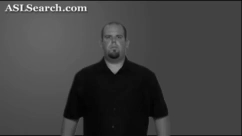

torch.Size([1, 136, 242])


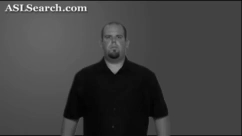

video_id    7099
label       book
offset       130
length        44
Name: 4, dtype: object


In [ ]:
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, Subset, DataLoader
from IPython import display
import torch
import time
from PIL import Image
import decord
DEVICE = 'cuda'

torch.set_default_dtype(torch.float16)
decord.bridge.set_bridge('torch')

class VideoDataset(Dataset):
    def __init__(self, annotations_file, vid_file, device):
        self.annotations = pd.read_csv(annotations_file)
        labels = self.annotations['label']
        self.label_map = {c: i for i, c in enumerate(set(labels))}
        self.labels = torch.tensor([self.label_map[s] for s in labels]).to(device)
        self.cap = decord.VideoReader(vid_file)
        self.device = device

    def __len__(self):
        return len(self.annotations)
    
    def get_clips(self, clips: list[range]):
        frames = self.cap.get_batch([i for clip in clips for i in clip])
        frames = frames.data[:, :, :, 0] / (255 / 2) - 1
        
        frames = frames.unsqueeze(1)

        batch = []
        i = 0
        for r in clips:
            l = len(r)
            clip = frames[i: l]
            batch.append(clip)
            
        return batch
    
    def get_vid(self, idx):
        offset, length, _ = self[idx]
        return self.get_clips([range(offset, offset + length)])

    def __getitem__(self, idx):
        row = self.annotations.loc[idx]
        return row['offset'], row['length'], self.labels[idx]

def show_frame(frame):
    frame.cpu()
    frame = (frame + 1) * (255 / 2)
    print(frame.shape)
    display.display(Image.fromarray(frame[0, :, :].numpy().astype(np.uint8)))

def play_video(vid):
    vid = ds.get_vid(vid)[0].cpu()
    for frame in vid[:,0,:,:]:
        display.clear_output(wait=True)
        show_frame(frame)
        time.sleep(1/15)
    
def get_first_last(vid):
    frame_start = vid[0][0].cpu()
    frame_end = vid[-1][0].cpu()
    
    show_frame(frame_start)
    show_frame(frame_end)

def stats(i):
    get_first_last(ds.get_vid(i))
    print(ds.annotations.loc[i])
        
ds = VideoDataset('labels.csv', 'wlasl_downsampled.mp4', DEVICE)

stats(4)

In [38]:
import torch
from sklearn.model_selection import train_test_split
import torch.nn.utils.rnn as rnn_utils

TEST_SIZE = 0.2
BATCH_SIZE = 64
SEED = 10

train_i, test_i = train_test_split(
    range(len(ds)),
    stratify=ds.annotations['label'],
    test_size=TEST_SIZE,
    random_state=SEED
    )

torch.manual_seed(SEED)

train_split = Subset(ds, train_i)
test_split = Subset(ds, test_i)

def collate(batch):
    batch.sort(key=lambda x: x[0], reverse=True)

    videos = ds.get_clips([range(o + 1, o + l - 1) for o, l, _ in batch])

    batch.sort(key=lambda x: x[1], reverse=True)
    
    offsets, lengths, labels = zip(*batch)

    padded_videos = rnn_utils.pad_sequence(videos).to(DEVICE)

    lengths = [l - 2 for l in lengths]
    
    return padded_videos, lengths, torch.stack(labels)

train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate)
test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, collate_fn=collate)

In [ ]:
from torch import nn

class FullyConnected(nn.Module):
    def __init__(self, out):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LazyLinear(out),
            nn.LazyBatchNorm1d(),
            nn.LeakyReLU(),
        )
    def forward(self, inp):
        return self.layers(inp)

class Conv2d(nn.Module):
    def __init__(self, out_channels, kernel_size, stride):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LazyConv2d(out_channels, kernel_size, stride),
            nn.LazyBatchNorm2d(),
            nn.LeakyReLU(),
        )
    def forward(self, inp):
        return self.layers(inp)


class TransformerModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(0, 1),
            nn.MaxPool2d(2, 2),
            Conv2d(out_channels=2, kernel_size=2, stride=1),
            Conv2d(out_channels=4, kernel_size=6, stride=2),
            Conv2d(out_channels=16, kernel_size=6, stride=2),
            nn.Flatten(1),
            FullyConnected(2048),
            FullyConnected(1024),
            FullyConnected(1024),
            )

        self.rnn = nn.RNN(1024, 512, 4)

        self.output = nn.Sequential(
            FullyConnected(512),
            nn.Linear(512, 1910),
        )


    def forward(self, inp, lengths):
        x = inp
        frames, batch, channels, h, w = x.shape
        x = self.layers(x)
        x = x.view(frames, batch, -1)
        x = rnn_utils.pack_padded_sequence(x, lengths, enforce_sorted=False)
        x, h = self.rnn(x)
        x = h[0, :, :]
        output = self.output(x)
        
        return output

model = TransformerModule()
model.to(DEVICE)

def print_hook(module, args, output):
    inp = args[0]
    
    if isinstance(inp, torch.Tensor):
        dtype = inp.dtype
        inp = inp.shape
    elif isinstance(inp, rnn_utils.PackedSequence):
        dtype = inp.data.dtype
        inp = inp.data.shape
    
    if isinstance(output, tuple):
        output = output[0]
    outp = output.shape
    name = type(module).__name__
    print(f'{name}: {inp}, {outp}, {dtype}')

handles = []

# Apply Xavier initialization
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

for child in model.children():
    if child.children():
        for child_ in child.children():
            handles.append(child_.register_forward_hook(print_hook))
    else:
        handles.append(child.register_forward_hook(print_hook))

sample, lengths, _ = next(iter(train_batches))

result = model(sample, lengths)

print(result.shape)

for handle in handles:
    handle.remove()

Flatten: torch.Size([96, 64, 1, 136, 242]), torch.Size([6144, 1, 136, 242]), torch.float16
Flatten: torch.Size([6144, 1, 136, 242]), torch.Size([6144, 32912]), torch.float16
FullyConnected: torch.Size([6144, 32912]), torch.Size([6144, 1024]), torch.float16
FullyConnected: torch.Size([64, 512]), torch.Size([64, 512]), torch.float16
Linear: torch.Size([64, 512]), torch.Size([64, 1910]), torch.float16
Sigmoid: torch.Size([64, 1910]), torch.Size([64, 1910]), torch.float16
torch.Size([64, 1910])


In [ ]:
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm
from torch import profiler

model.apply(initialize_weights)

criterion = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001, eps=1e-3)
torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

num_epochs = 20

torch.autograd.set_detect_anomaly(True)

# with profiler.profile(
#     activities=[
#         profiler.ProfilerActivity.CPU,
#         profiler.ProfilerActivity.CUDA,
#     ]
# ) as prof:
#     def a():

correct = 0
total = 0
with profiler.record_function("model_forward"):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, lengths, annotations in tqdm(train_batches, smoothing=0.8):
            optimizer.zero_grad()
            outputs = model(inputs, lengths)
            _, predicted = torch.max(outputs.data, 1)
            
            loss = criterion(outputs, annotations)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            total += annotations.size(0)
            correct += (predicted == annotations).sum().item()
            # print(f"Loss: {loss.item()}")
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_batches)}, Accuracy: {100 * correct / total}%")

    # a()

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, lengths, annotations in tqdm(test_batches, smoothing=0.8):
        outputs = model(inputs, lengths)
        _, predicted = torch.max(outputs.data, 1)
        total += annotations.size(0)
        correct += (predicted == annotations).sum().item()

print(f"Accuracy: {100 * correct / total}%")

100%|██████████| 147/147 [01:26<00:00,  1.71it/s]


Epoch 1/2, Loss: 7.5655824829931975, Accuracy: 0.021328783192918845%


100%|██████████| 147/147 [01:24<00:00,  1.73it/s]


Epoch 2/2, Loss: 7.552774234693878, Accuracy: 0.06931854537698624%
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                          model_forward         7.48%       13.713s        93.38%      171.186s      171.186s       13.083s         7.13%      171.189s      171.189s             1  
enumerate(DataLoader)#_SingleProcessDataLoaderIter._...        45.99%       84.301s        79.84%      146.358s     494.453ms       83.843s 

100%|██████████| 37/37 [00:29<00:00,  1.27it/s]

Accuracy: 0.042643923240938165%
